# How to run SPAMM

The only required inputs to run `SPAMM` are:
1. A source AGN spectrum
2. A list of which components to fit

However, there are numerous optional input arguments available. Since there are dozens of optional parameters, they have been separated out into a configuration file, `parameters.yaml`. An example default file is provided in `spamm/utils/parameters.yaml`. Users will want to modify this file or create their own with the same format. Any parameters file can be specified at runtime- if one is not found, the default will be used.

## Getting Started

`SPAMM` can accept the required input spectrum in three different forms: 
1. `spamm.Spectrum` instance
2. `specutils.Spectrum1D` instance
3. tuple containing the wavelength and flux and optionally, the error on the flux

All three methods will be shown below.

The list of acceptable components to fit are listed below (they are case insensitive):
- `PL` (Power Law)
- `FE` (Iron Forect)
- `HG` (Host Galaxy)
- `BC` (Balmer Continuum)
- `BPC` (Balmer Pseudo Continuum)
- `NEL` (Narrow Emission Lines)
- `CALZETTI_EXT` (Calzetti extinction curves)
- `SMC_EXT` (Small Magellanic Cloud extinction curves)
- `LMC_EXT` (Large Magellanic Cloud extinction curves)
- `MW_EXT` (Milky Way extinction curves)
- `AGN_EXT` (AGN extinction curves)

For all of our examples, we'll just use the Power Law component so that computation time is fast.

In [1]:
%config InlineBackend.figure_format = "retina"

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import astropy.units as u

from spamm.run_spamm import spamm
from spamm.Spectrum import Spectrum

### Creating a mock spectrum

In [23]:
# Define the unit-less wavelength and flux
wave = np.arange(1000., 4000., 1)

amp = 1e-17
alpha = -2.0
x0 = np.median(wave)

# Just generate a simple sample power law for a spectrum
def powerlaw(x, x0, amp, alpha):
    return amp * (x/x0)**alpha
    
flux = powerlaw(wave, x0, amp, alpha)

# Make the error 5% of the flux array 
flux_error = flux * 0.05

### Plotting the mock spectrum

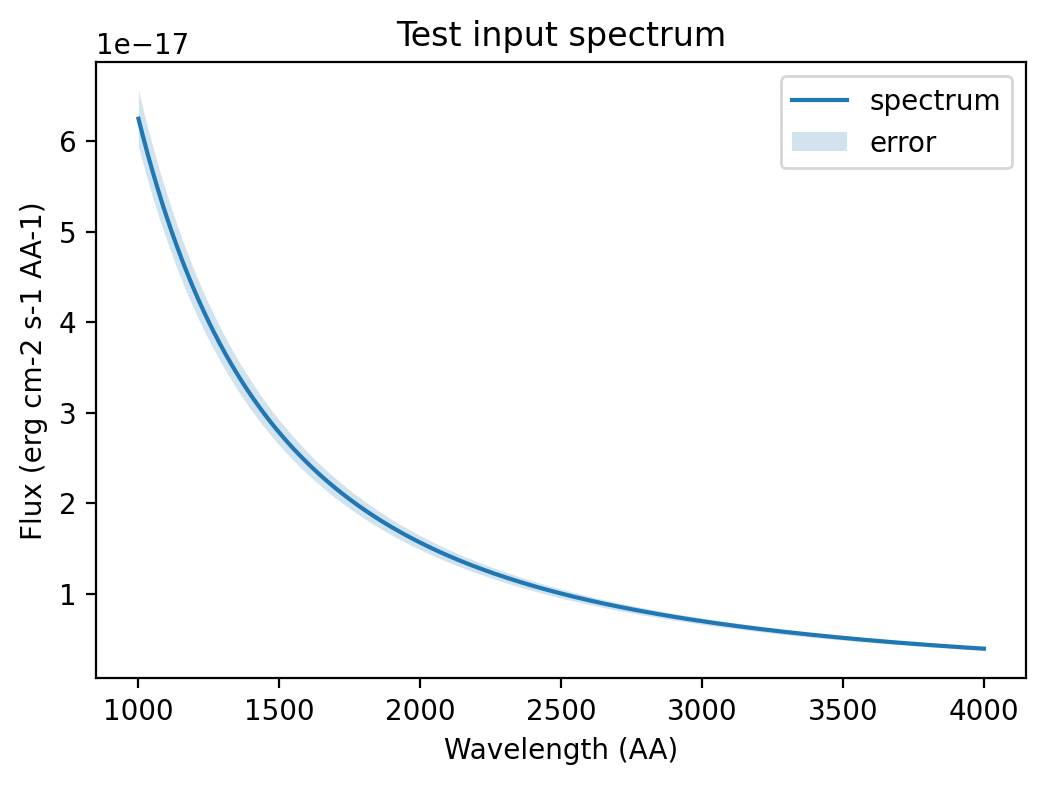

In [24]:
fig = plt.figure(figsize=(6,4))
plt.plot(wave, flux, label='spectrum')
plt.fill_between(wave, flux - flux_error, flux + flux_error, color='C0', alpha=0.2, lw=0, label='error')

plt.xlabel("Wavelength (AA)")
plt.ylabel("Flux (erg cm-2 s-1 AA-1)")
plt.title("Test input spectrum")
plt.legend();

### From a `spamm.Spectrum` instance

In [25]:
# If no wavelength and flux units are provided upon instantiation, 
# they will be retrieved from the parameters.yaml file.
inspectrum = Spectrum(spectral_axis=wave, flux=flux, flux_error=flux_error,
                      spectral_axis_unit=u.AA, flux_unit=u.Unit('erg cm-2 s-1 AA-1'))

# Let's run SPAMM using a single Power Law component.
spamm_out = spamm(complist=["PL"], inspectrum=inspectrum)

100%|████████████████████████████████████████| 500/500 [00:02<00:00, 242.89it/s]


[SPAMM]: Mean acceptance fraction: 0.310
[SPAMM]: Saved pickle file: 20240815_5415/model_20240815_5415.pickle.gz
[SPAMM]: Execution time: 2.127 seconds


### MCMC input arguments
You can also specify the number of walkers and iterations for `emcee` ([documentation here](https://emcee.readthedocs.io/en/stable/)). 

In [27]:
# Let's run SPAMM using a single Power Law component.
spamm_out = spamm(complist=["PL"], inspectrum=inspectrum, n_walkers=32, n_iterations=2000)

100%|██████████████████████████████████████| 2000/2000 [00:10<00:00, 198.61it/s]


[SPAMM]: Mean acceptance fraction: 0.611
[SPAMM]: Saved pickle file: 20240815_0052/model_20240815_0052.pickle.gz
[SPAMM]: Execution time: 10.372 seconds


### From a `specutils.Spectrum1D` instance
The most important thing to note when starting from a `specutils.Spectrum1D` object is that `Spectrum1D` requires the wavelength and flux arrays to be `astropy.unit.Quantity` objects. While an input uncertainty is an optional parameter when instantiating `Spectrum1D`, it is required when instantiating a `spamm.Spectrum` object and therefore should be passed into `Spectrum1D` before using `spamm`. 
`Spectrum1D` requires the uncertainty to be an `astropy.nddata.NDUncertainty` object.

In [6]:
from specutils import Spectrum1D
from astropy.nddata import StdDevUncertainty

In [7]:
# specutils.Spectrum1D objects must be instantiated with units.
wavelength_q = wave * u.AA
flux_q = flux * u.Unit('erg cm-2 s-1 AA-1')
flux_error_q = flux_q * 0.05
# Explicit array and unit arguments are shown below to illustrate how they are passed in.
uncertainty = StdDevUncertainty(flux_error_q.value, unit=flux_error_q.unit)

In [8]:
inspectrum = Spectrum1D(spectral_axis=wavelength_q, flux=flux_q, uncertainty=uncertainty)
spamm_out = spamm(complist=["PL"], inspectrum=inspectrum, n_walkers=32, n_iterations=2000)

100%|██████████████████████████████████████| 2000/2000 [00:09<00:00, 215.65it/s]


[SPAMM]: Mean acceptance fraction: 0.611
[SPAMM]: Saved pickle file: 20240815_5210/model_20240815_5210.pickle.gz
[SPAMM]: Execution time: 9.567 seconds


### From a tuple

In [9]:
# Create a tuple with the wavelength, flux, and flux error arrays. 
intup = (wave, flux, flux_error)

In [10]:
# Note that when the input spectrum is defined as a tuple, 
# the wavelength and flux units will be retrieved from the parameters file.
spamm_out = spamm(complist=["PL"], inspectrum=intup, n_walkers=32, n_iterations=2000)

100%|██████████████████████████████████████| 2000/2000 [00:09<00:00, 214.76it/s]


[SPAMM]: Mean acceptance fraction: 0.612
[SPAMM]: Saved pickle file: 20240815_5220/model_20240815_5220.pickle.gz
[SPAMM]: Execution time: 9.588 seconds


### Specifying an input parameters file
An input `parameters.yaml` can be specified on runtime using the `par_file` argument. If one is not specified, the default file will be used.

In [11]:
# Uncomment this if you want to try it.
#spamm_out = spamm(complist=["PL"], inspectrum=inspectrum, par_file="path/to/my/parameters.yaml")

### Specifying output file names and locations
There are several output files (see below); it is possible to change their default names and locations. For the output pickle file:

In [12]:
# You can choose to include the extension name or not, both options below are acceptable.
#spamm_out = spamm(complist=["PL"], inspectrum=inspectrum, picklefile="mypicklefile")
#spamm_out = spamm(complist=["PL"], inspectrum=inspectrum, picklefile="mypicklefile.pickle.gz")

The output directory need not exist, it will be created if necessary. To change the directory where the pickle file and plots will be written:

In [13]:
#spamm_out = spamm(complist=["PL"], inspectrum=inspectrum, outdir="/path/to/my/output", picklefile="mypicklefile")

In [14]:
spamm_out = spamm(complist=['PL'], inspectrum=inspectrum, n_walkers=32, n_iterations=2000)

100%|██████████████████████████████████████| 2000/2000 [00:09<00:00, 208.31it/s]


[SPAMM]: Mean acceptance fraction: 0.613
[SPAMM]: Saved pickle file: 20240815_5230/model_20240815_5230.pickle.gz
[SPAMM]: Execution time: 9.897 seconds


### Multiprocessing

SPAMM can operate concurrently across multiple CPUs when `parallel=True` is set. By default, SPAMM engages all available cores on your machine. While there is inherent overhead, significant speed improvements may not be evident in basic scenarios, such as the power law. In fact, you may notice that running SPAMM on a simple power law with parallel processing is significantly slower than running it in serial. However, incorporating numerous components into SPAMM increases computational demands, making parallelization highly beneficial.

In [15]:
spamm_out = spamm(complist=['PL'], inspectrum=inspectrum, n_walkers=32, n_iterations=2000, parallel=True)

100%|██████████████████████████████████████| 2000/2000 [00:12<00:00, 158.62it/s]


[SPAMM]: Mean acceptance fraction: 0.608
[SPAMM]: Saved pickle file: 20240815_5244/model_20240815_5244.pickle.gz
[SPAMM]: Execution time: 14.612 seconds


### Masking

Additionally, it's possible to integrate a mask into your configuration. Setting `mask = [(w1, w2), (w3, w4), (w5, w6)]` enables you to filter out designated wavelength ranges, such as from `w1 to w2`, `w3 to w4`, and others. The mask parameter can also take a Boolean list or a NumPy array corresponding to the length of your wavelength array. Within this mask, unmasked wavelengths are indicated by `True`, while those that need to be masked are labeled as `False`.

In [16]:
# Here we arbitrarily mask the wavelength range 400-700 Å and 1100-1200 Å:
mask = [(400, 700), (1100, 1200)]
spamm_out = spamm(complist=['PL'], inspectrum=inspectrum, mask=mask, n_walkers=32, n_iterations=2000, parallel=False)

100%|██████████████████████████████████████| 2000/2000 [00:09<00:00, 204.67it/s]


[SPAMM]: Mean acceptance fraction: 0.614
[SPAMM]: Saved pickle file: 20240815_5254/model_20240815_5254.pickle.gz
[SPAMM]: Execution time: 10.067 seconds


### Running from the command line
`SPAMM` is designed to be run programatically. Sorry.

## Interpreting the results

### Output files
#### Pickle file
For each successful `SPAMM` run, an output pickle file will be written. By default this filename will reflect the datetime at code finish with the following format:<br/>
`model_YYYYMMDD_mmss.pickle.gz`<br/>
e.g. `model_20191231_1059.pickle.gz`<br/>

Pickle files are by default written to a directory with the same runtime string, e.g.:<br/>
`20191231_1059/model_20191231_1059.pickle.gz`.

As mentioned above, though, both the output directory name and pickle filename can be specified at runtime. 

The pickle file contains all information regarding the results from `emcee`. To read this pickle file in, use the `Samples` class. Let's run SPAMM and save our output to a custom directory of our choosing, and then analyze the results stored inside of that directory:

In [17]:
from spamm.Samples import Samples

# Let's fit only the Power Law component.
spamm_out = spamm(complist=["PL"], inspectrum=inspectrum, n_walkers=32, n_iterations=2000,
                  parallel=False, outdir='powerlaw_example', picklefile='powerlaw')

100%|██████████████████████████████████████| 2000/2000 [00:09<00:00, 209.96it/s]


[SPAMM]: Mean acceptance fraction: 0.614
[SPAMM]: Saved pickle file: powerlaw_example/powerlaw.pickle.gz
[SPAMM]: Execution time: 9.828 seconds


In [18]:
S = Samples("powerlaw_example/powerlaw.pickle.gz", burn=1000)

# Some useful attributes of a Samples object
print(f"The pickle file name is:\n\t{S.pname}\n")
print(f"The component parameter names are:\n\t{S.model_parameter_names}\n")
print(f"The max values on the PDF for these parameters are:\n\t{S.maxs:}")

The pickle file name is:
	powerlaw_example/powerlaw.pickle.gz

The component parameter names are:
	['norm_PL', 'slope1']

The max values on the PDF for these parameters are:
	[np.float64(9.999734269261168e-18), np.float64(-1.9997344185108297)]


In [19]:
# You can also access the MCMC samples from emcee
print(S.samples)

[[ 1.00020889e-17 -1.99259383e+00]
 [ 1.00020889e-17 -1.99259383e+00]
 [ 1.00026232e-17 -1.99306617e+00]
 ...
 [ 1.00044302e-17 -1.99935732e+00]
 [ 1.00148432e-17 -1.99977727e+00]
 [ 1.00140381e-17 -2.00043410e+00]]


#### Corner plot
The corner plot shows the projections of a set of samples in a multi-dimensional space. This is useful for visualizing the MCMC chain. Here we are using the `corner` package in python to visualize it. Here I also display the 16%, 50% and 84% quantiles as well as the truth values.

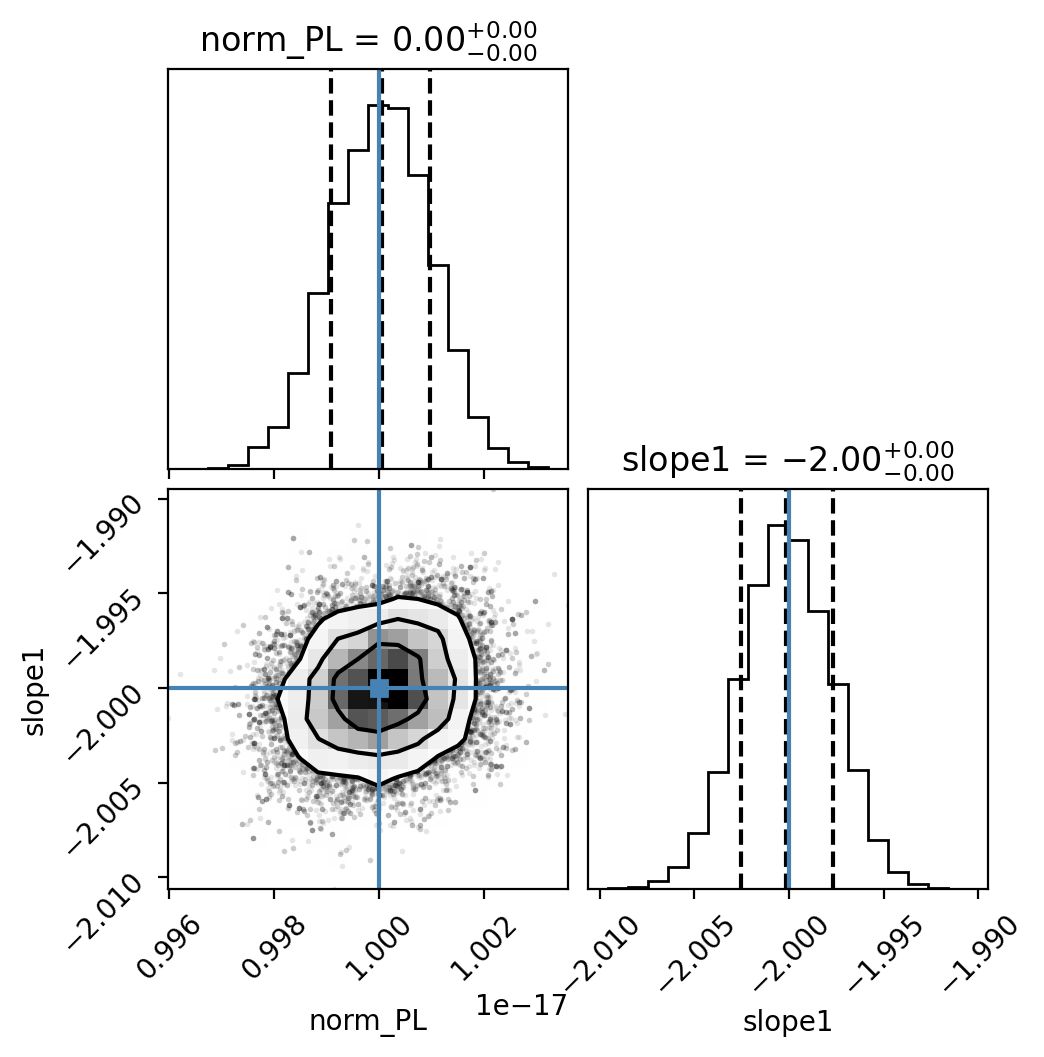

In [20]:
import corner

flat_samples = S.model.sampler.get_chain(discard=1000, flat=True)
fig = corner.corner(flat_samples, 
                    labels=S.model_parameter_names, 
                    quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True,
                    truths=[amp, alpha]);

In [21]:
S.samples

array([[ 1.00020889e-17, -1.99259383e+00],
       [ 1.00020889e-17, -1.99259383e+00],
       [ 1.00026232e-17, -1.99306617e+00],
       ...,
       [ 1.00044302e-17, -1.99935732e+00],
       [ 1.00148432e-17, -1.99977727e+00],
       [ 1.00140381e-17, -2.00043410e+00]])

Let's inspect the final model, evaluated using the mean as an estimator:

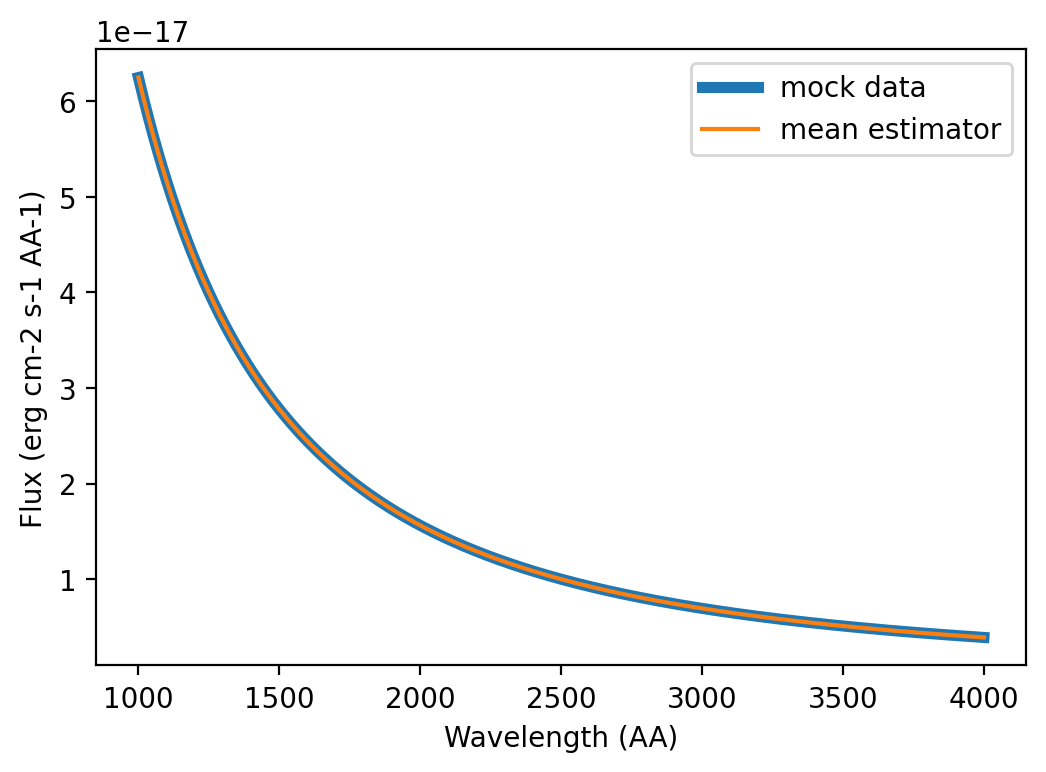

In [22]:
fig = plt.figure(figsize=(6,4))
mean_vals = np.mean(S.samples, axis=0)

plt.plot(wave, flux, lw=4, label='mock data')
plt.plot(wave, powerlaw(x=wave, x0=np.median(wave), amp=mean_vals[0], alpha=mean_vals[1]), label='mean estimator');
plt.xlabel("Wavelength (AA)")
plt.ylabel("Flux (erg cm-2 s-1 AA-1)")
plt.legend()